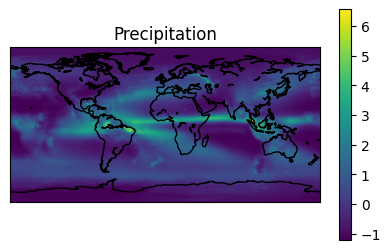

In [2]:
import sys
sys.path.append('./satclip')
import matplotlib.pyplot as plt
import torch
from load import get_satclip
from mpl_toolkits.basemap import Basemap
from urllib import request
import numpy as np
import pandas as pd
import io
import torch
from torch.utils.data import TensorDataset, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Automatically select device
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, dim_hidden, num_layers, out_dims):
        super(MLP, self).__init__()

        layers = []
        layers += [nn.Linear(input_dim, dim_hidden, bias=True), nn.ReLU()] # Input layer
        layers += [nn.Linear(dim_hidden, dim_hidden, bias=True), nn.ReLU()] * num_layers # Hidden layers
        layers += [nn.Linear(dim_hidden, out_dims, bias=True)] # Output layer

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

def convert_to_lat_lon(data):
    """
    Converts a list of numbers between 0 and 64799 to a list of latitudes and longitudes within the range [-89, 90] and [-180, 179].

    Args:
        data (list): A list of numbers between 0 and 64799.

    Returns:
        list: A list of tuples representing latitudes and longitudes.
    """

    latitudes = []
    longitudes = []

    for number in data:
        # Convert number to latitude and longitude coordinates
        latitude = (number // 360) - 89
        longitude = (number % 360) - 180

        # Append coordinates to lists
        latitudes.append(latitude)
        longitudes.append(longitude)

    return list(zip(latitudes, longitudes))

def calculate_lat_lon(row):
    # 这里是你的函数，我假设它是func
    # import ipdb; ipdb.set_trace()
    lat, lon = convert_to_lat_lon([row.name])[0]
    lat = lat + 0.5
    lon = lon + 0.5
    return pd.Series({'lat': lat, 'lon': lon})

def get_precipitation_data(pred="temp",
                      norm_y=True,
                      norm_x=True
                      ):
    '''
    Download and process the Global Air Temperature dataset (more info: https://www.nature.com/articles/sdata2018246)

    Parameters:
    pred = numeric; outcome variable to be returned; choose from ["temp", "prec"]
    norm_y = logical; should outcome be normalized
    norm_min_val = integer; choice of [0,1], setting whether normalization in range[0,1] or [-1,1]

    Return:
    coords = spatial coordinates (lon/lat)
    x = features at location
    y = outcome variable
    '''
    #   url = 'https://springernature.figshare.com/ndownloader/files/12609182'
    #   url_open = request.urlopen(url)
    
    # inc = np.array(pd.read_csv(io.StringIO(url_open.read().decode('utf-8'))))
    inc = pd.read_csv('../data/precipitation_avg_day.csv',names=['precipitation_value'])
    # 定义函数来计算经纬度

    # 计算经纬度并添加到DataFrame
    inc[['lat', 'lon']] = inc.apply(calculate_lat_lon, axis=1)
    inc = np.array(inc)
    y = inc[:,0].reshape(-1)
    coords = inc[:,1:]
    # import ipdb; ipdb.set_trace()
    coords = coords[:,::-1]
    
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std

    return torch.tensor(coords.copy()),  torch.tensor(y), y_mean, y_std



#先lon再lat
coords, y, y_mean, y_std = get_precipitation_data()
# print(coords)
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
scatter = ax.scatter(coords[:,0], coords[:,1], c=y, s=5)
ax.set_title('Precipitation')

# 添加colorbar
cbar = plt.colorbar(scatter)
# cbar.set_label('wind')

plt.show()


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpmg4osywx
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpmg4osywx/_remote_module_non_scriptable.py


using pretrained moco vit16
torch.Size([64800, 2])
torch.Size([64800, 256])


Text(0.5, 1.0, 'Train-Test Split')

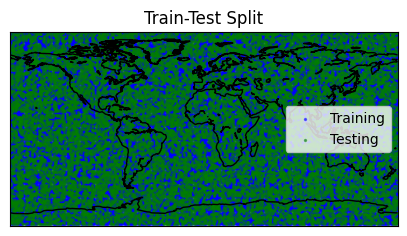

In [3]:

# import ipdb; ipdb.set_trace()
satclip_path = './satclip-vit16-l10.ckpt'

model = get_satclip(satclip_path, device=device) # Only loads location encoder by default
model.eval()
with torch.no_grad():
  x  = model(coords.double().to(device)).detach().cpu()

print(coords.shape)
print(x.shape)


dataset = TensorDataset(coords, x, y)

# train_size = int(0.8 * len(dataset))
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

coords_train, x_train, y_train = train_set.dataset.tensors[0][train_set.indices], train_set.dataset.tensors[1][train_set.indices], train_set.dataset.tensors[2][train_set.indices]
coords_test, x_test, y_test = test_set.dataset.tensors[0][test_set.indices], test_set.dataset.tensors[1][test_set.indices], test_set.dataset.tensors[2][test_set.indices]

fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(coords_train[:,0], coords_train[:,1], c='blue', s=2, label='Training',alpha=0.5)
ax.scatter(coords_test[:,0], coords_test[:,1], c='green', s=2, label='Testing',alpha=0.5)
ax.legend()
ax.set_title('Train-Test Split')


Epoch 250, MSE Loss: 0.0269
Epoch 250, MAE Loss: 0.0957
Epoch 500, MSE Loss: 0.0185
Epoch 500, MAE Loss: 0.0769
Epoch 750, MSE Loss: 0.0158
Epoch 750, MAE Loss: 0.0708
Epoch 1000, MSE Loss: 0.0148
Epoch 1000, MAE Loss: 0.0697
Epoch 1250, MSE Loss: 0.0184
Epoch 1250, MAE Loss: 0.0823
Epoch 1500, MSE Loss: 0.0107
Epoch 1500, MAE Loss: 0.0568
Epoch 1750, MSE Loss: 0.0108
Epoch 1750, MAE Loss: 0.0588
Epoch 2000, MSE Loss: 0.0109
Epoch 2000, MAE Loss: 0.0594
Epoch 2250, MSE Loss: 0.0104
Epoch 2250, MAE Loss: 0.0580
Epoch 2500, MSE Loss: 0.0086
Epoch 2500, MAE Loss: 0.0504
Epoch 2750, MSE Loss: 0.0134
Epoch 2750, MAE Loss: 0.0695
Epoch 3000, MSE Loss: 0.0084
Epoch 3000, MAE Loss: 0.0509
Epoch 3250, MSE Loss: 0.0079
Epoch 3250, MAE Loss: 0.0486
Epoch 3500, MSE Loss: 0.0078
Epoch 3500, MAE Loss: 0.0481
Epoch 3750, MSE Loss: 0.0081
Epoch 3750, MAE Loss: 0.0504
Epoch 4000, MSE Loss: 0.0116
Epoch 4000, MAE Loss: 0.0664
Epoch 4250, MSE Loss: 0.0096
Epoch 4250, MAE Loss: 0.0576
Epoch 4500, MSE Loss

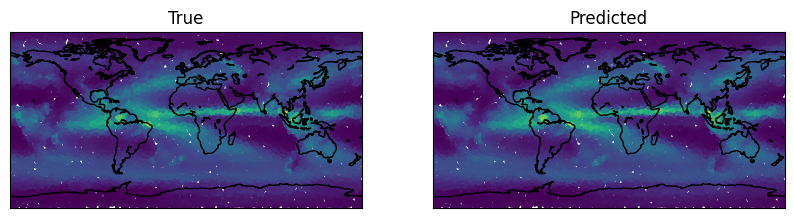

In [4]:
# plt.savefig('pra.jpg')
# import ipdb; ipdb.set_trace()
pred_model = MLP(input_dim=256, dim_hidden=64, num_layers=2, out_dims=1).float().to(device)
criterion = nn.MSELoss() #mae
# criterion = nn.L1Loss() #MAE
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)

losses = []
epochs = 50000
patience = 100  # Number of epochs to wait for improvement before stopping
best_loss = float('inf')
stop_counter = 0

for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = pred_model(x_train.float().to(device))
    # Compute the loss
    loss = criterion(y_pred.reshape(-1), y_train.float().to(device))
    # Backward pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Append the loss to the list
    losses.append(loss.item())
    if (epoch + 1) % 250 == 0:
        print(f"Epoch {epoch + 1}, MSE Loss: {loss.item():.4f}")
        print(f"Epoch {epoch + 1}, MAE Loss: {nn.L1Loss()(y_pred.reshape(-1), y_train.float().to(device)).item():.4f}")
    
    
    # Check if the validation loss has improved
    if loss.item() < best_loss:
        best_loss = loss.item()
        stop_counter = 0
    else:
        stop_counter += 1
    if stop_counter >= patience:
        print("Early stopping triggered")
        break

with torch.no_grad():
    model.eval()
    y_pred_test = pred_model(x_test.float().to(device))

# Print test loss
print(f'Test MSE loss: {criterion(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')
print(f'Test MAE loss: {nn.L1Loss()(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
ax[0].scatter(coords_test[:,0], coords_test[:,1], c=y_test, s=5)
ax[0].set_title('True')

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
ax[1].scatter(coords_test[:,0].cpu().numpy(), coords_test[:,1].cpu().numpy(), c=y_pred_test.reshape(-1).cpu().numpy(), s=5)
ax[1].set_title('Predicted')
plt.savefig('precipitation_predicted_day_satclip.jpg')

[1.0069912672042847, 0.9189006686210632, 0.8529216647148132, 0.7988027930259705, 0.7522727847099304, 0.7170534729957581, 0.6969645619392395, 0.6894075274467468, 0.6822851300239563, 0.66765958070755, 0.644879162311554, 0.6176641583442688, 0.5916449427604675, 0.5732546448707581, 0.5637540817260742, 0.5543236136436462, 0.5379499793052673, 0.518144428730011, 0.5030282139778137, 0.4953226149082184, 0.4880053699016571, 0.47624796628952026, 0.464523047208786, 0.45491155982017517, 0.4431646168231964, 0.4307357966899872, 0.42093271017074585, 0.4099394381046295, 0.3976810872554779, 0.3882558345794678, 0.37958648800849915, 0.3676362633705139, 0.3553107678890228, 0.3451503813266754, 0.3351767361164093, 0.32546427845954895, 0.3151992857456207, 0.30498066544532776, 0.29659193754196167, 0.28638046979904175, 0.2777867019176483, 0.26921340823173523, 0.26158255338668823, 0.25199007987976074, 0.24395596981048584, 0.23570747673511505, 0.2281918227672577, 0.22044242918491364, 0.21358583867549896, 0.2066514

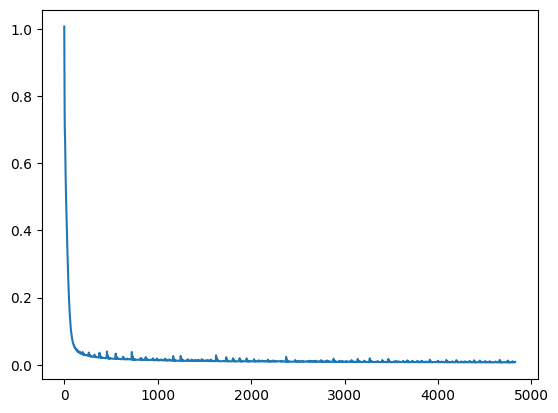

In [5]:
print(losses)
plt.plot(losses)

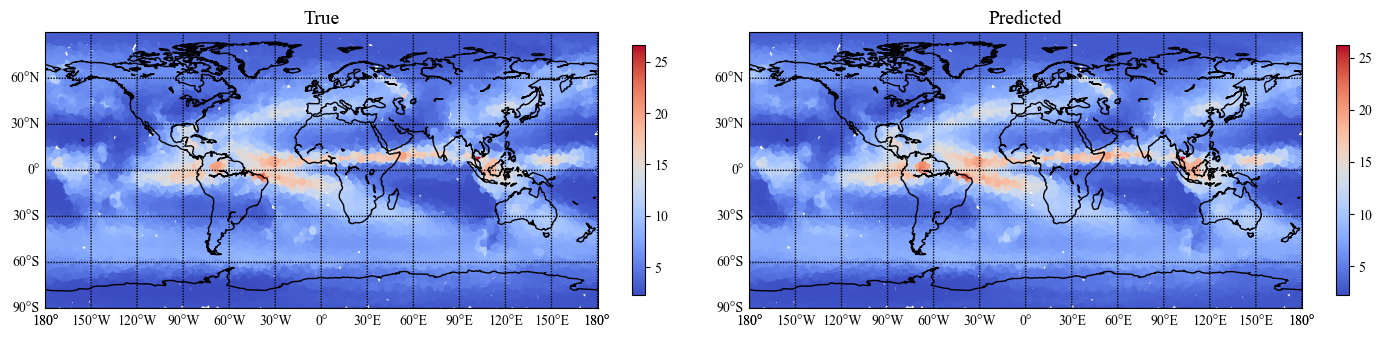

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
y_test = y_test * y_std + y_mean
y_pred_test = y_pred_test * y_std + y_mean
m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
m.drawmeridians(np.arange(-180, 180, 30), labels=[0,0,0,1])  # 绘制经线
m.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0])  # 绘制纬线
scatter_true = ax[0].scatter(coords_test[:,0], coords_test[:,1], c=y_test, s=20,
                             cmap='coolwarm')
ax[0].set_title('True', fontsize=14)

# 添加颜色条
cbar_true = plt.colorbar(scatter_true, ax=ax[0], shrink=0.65)
# cbar_true.set_label('True Values', fontsize=12)

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
m.drawmeridians(np.arange(-180, 180, 30), labels=[0,0,0,1])  # 绘制经线
m.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0])  # 绘制纬线
scatter_pred = ax[1].scatter(coords_test[:,0].cpu().numpy(), coords_test[:,1].cpu().numpy(), c=y_pred_test.reshape(-1).cpu().numpy(),
                             s=20,
                             cmap='coolwarm')
ax[1].set_title('Predicted', fontsize=14)

# 添加颜色条
cbar_pred = plt.colorbar(scatter_pred, ax=ax[1], shrink=0.65)
# cbar_pred.set_label('Predicted Values', fontsize=12)
# 调整子图之间的距离
plt.subplots_adjust(wspace=0.02)
# plt.tight_layout()
plt.savefig('satclip_precipitation_predicted_day.pdf', dpi=1000,
            bbox_inches='tight'
            )